# Projeto Pytorch

Realizado por:​

Alexandre Santos Sousa  n.º119030​

Francisco Santos Sousa  n.º119121​

---

O objetivo deste projeto é desenvolver um modelo de rede neuronal capaz de processar imagens de palavras manuscritas e transcrever automaticamente o texto presente nestas.

Base de dados usada:

https://www.kaggle.com/datasets/landlord/handwriting-recognition/data

<img src="Imagens\Qr_Code.png" width="300">

# Configuração Inicial
### Importação de bibliotecas

In [1]:
# Bibliotecas
# Pytorch e Torchvision
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import v2

# Uteis
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import polars as pl
import os
from PIL import Image
timer = __import__('timeit').default_timer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

### Definição do device que irá processar os dados

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

### Indicar o caminho para os dados de treino e teste

In [3]:
# Caminhos para dados
TRAIN_DATA_DIR = "Dados/Dados Handwriting Recognition/train_v2/train"
TRAIN_DATA_LABELS = "Dados/Dados Handwriting Recognition/written_name_train_v2.csv"
TEST_DATA_DIR = "Dados/Dados Handwriting Recognition/test_v2/test"
TEST_DATA_LABEL = "Dados/Dados Handwriting Recognition/written_name_test_v2.csv"

### Parâmetros/Tamanho das imagens 
Como a rede é feita para aceitar sempre o mesmo número de parâmetros de entrada, tem de se uniformizar o tamanho das imagens.

In [4]:
# Tamanho da imagem de entrada
IMG_HEIGHT = 64
IMG_WIDTH = 256

# Pré-Processamento
### Codificação dos caracteres 

In [5]:
# Charset e Codificação
charset = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"
char_to_idx = {char: idx + 1 for idx, char in enumerate(charset)}   # começa em 1
char_to_idx["blank"] = 0                                            # índice reservado para o CTC
idx_to_char = {v: k for k, v in char_to_idx.items()}
num_classes = len(idx_to_char)
num_classes

28

### Transformações  a aplicar às imagens

In [6]:
# Transforms
transform = transforms.v2.Compose([
    transforms.v2.Resize((IMG_HEIGHT, IMG_WIDTH)),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

### DataSet personalizado para os dados utilizados
Como os dados não estão da forma correta para usar apenas o dataloader do pytorch vamos criar uma classe personalizada.

Esta vai buscar as imagens a uma pasta e os labels a um ficheiro excel.

In [7]:
# Dataset personalizado
class CustomDataSet(Dataset):
    def __init__(self, csv_file, num_imagens, image_dir, transforms=None, offset=0):
        
        labels = pl.read_csv(csv_file)
        labels = labels.filter(~labels["IDENTITY"].is_in(["UNREADABLE", "EMPTY"]))
        labels = labels.rename({"IDENTITY": "label"})
        if num_imagens is not None:
            labels = labels.slice(offset, num_imagens)

        self.labels = labels
        self.image_dir = image_dir
        self.transforms = transforms
        self.dataset = self._import_images()

    def _import_images(self):

        imagens = []
        self.paths = []
        ficheiros = self.labels["FILENAME"].to_list()
        for file_name in tqdm(ficheiros, desc="A carregar imagens", ncols=100):

            complete_dir = os.path.join(self.image_dir, file_name)

            try:

                img = Image.open(complete_dir).convert("L")
                if self.transforms:
                    img = self.transforms(img)
                imagens.append(img)
                self.paths.append(file_name)

            except Exception as e:

                print(f"Erro ao carregar {file_name}: {e}")

        print(f"Foram carregadas {len(imagens)} imagens com sucesso.")
        return imagens

    def __len__(self):
        return len(self.dataset)

    # Devolve tuplo(imagem, label)
    def __getitem__(self, idx):
        image = self.dataset[idx]
        label = self.labels[idx, "label"]
        if label is None or not isinstance(label, str):
            label = ""
        return image, label

# Visualização de dados
Importar imagens de teste com o dataset.

In [8]:
# Validação
test_dataset  = CustomDataSet(TEST_DATA_LABEL, 10000, TEST_DATA_DIR, transform)
test_loader  = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

A carregar imagens:   0%|                                                 | 0/10000 [00:00<?, ?it/s]

Foram carregadas 10000 imagens com sucesso.


Visualização de algumas imagens de teste.

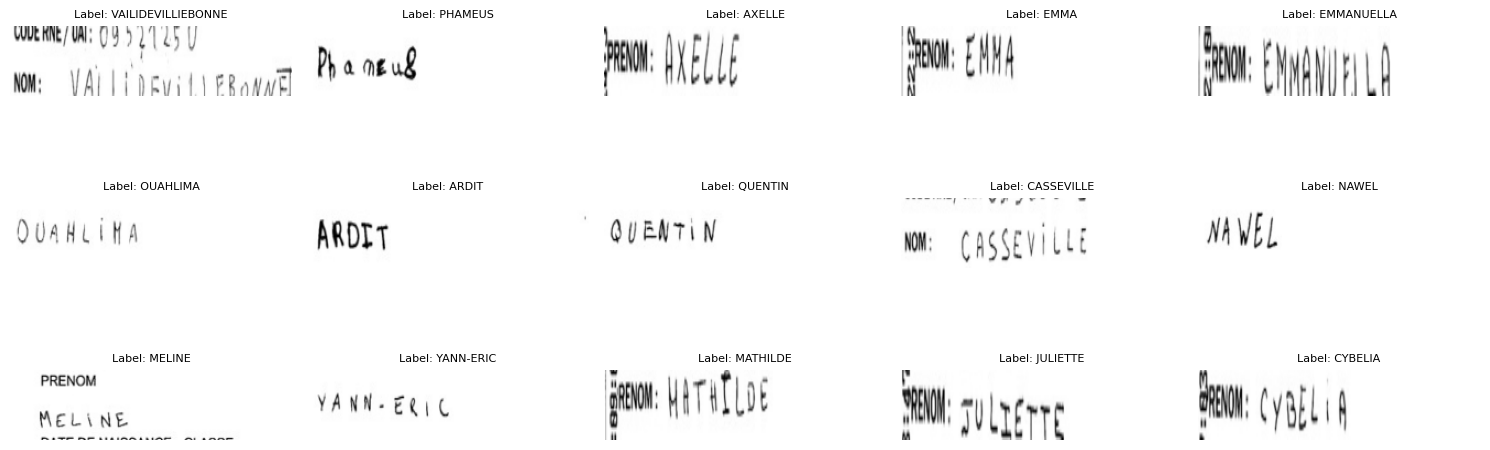

In [25]:
# Escolhe 15 imagens aleatórias de teste e mostra-as
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

for i in range(rows * cols):
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]
    ax = axes[i // cols, i % cols]
    ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Arquitetura do Modelo
Esta função define uma rede neuronal que combina redes convolucionais (CNN) para extrair características de imagens e redes recorrentes (RNN) bidirecionais para processar essas características numa sequência. No final, usa uma camada linear para processar os dados obtidos da rede RNN e classificar as imagens.

In [10]:
# Modelo
class RedeNeuronal(nn.Module):
    def __init__(self, num_classes):
        super(RedeNeuronal, self).__init__()
        # Parte Convolucional com 2 camadas
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # Aplicar a camada convolucional a um dummy para ver o tamanho de entrada na RNN
        dummy = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH)
        with torch.no_grad():
            out = self.conv_layer(dummy)
            _, C, H, W = out.shape
            input_size = W * C

        self.rnn1 = nn.GRU(input_size=input_size, hidden_size=512, num_layers=1,
                           bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=512*2, hidden_size=512, num_layers=1,
                           bidirectional=True, batch_first=True)
        self.fully_connected = nn.Linear(512 * 2, num_classes)      ## output size = 28 (alfabeto + - + "blank")

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.permute(0, 2, 1, 3) # [N, C, H, W] => [N, H, C, W]
        # contiguous serve para manter os dados num bloco linear de memória, como exigido pelo view
        x = x.contiguous().view(x.size(0), x.size(1), -1) # [N, H, C, W] => [N, H, C*W] : [Num Imagens, Time Steps, Resto dos Dados]
        # Como a rede RNN aceita parâmetros diferentes da CNN aplica-se uma tranformação
        # Para se ter entrada (batch_size, sequence_length, input_size)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.fully_connected(x)
        return x

Definição de uma Rede Neuronal do tipo : Entrada => Conv2D => Conv2D => RNN => RNN => Linear (Fully Connected)

Representação de uma rede CRNN, semelhante à usada.

![Image](Imagens/CRNN.png)

Exemplo de como funciona uma rede RNN:

![RNN](Imagens\RNN.png)

Numa rede RNN, a imagem é dividida em *time steps*, sendo que cada *time step* corresponde, por exemplo, a uma coluna de píxeis. Cada coluna é então analisada e, para a palavra 'while', por exemplo, obteríamos saídas como [ w, w, "\_", h, "_", ... ] que seriam posteriormente tratadas pela função de perda CTC Loss.

### Porque uma rede CRNN é a mais adequada para este trabalho?

A arquitetura CRNN (Convolutional Recurrent Neural Network) é especialmente eficaz para o reconhecimento de texto manuscrito devido à combinação de duas capacidades complementares:

1. A parte convolucional da rede (CNN) extrai características espaciais locais da imagem como bordas, curvas e padrões.

2. A parte recorrente GRU (RNN) modela a sequência temporal dessas características, capturando dependências entre caracteres ao longo do tempo.

Por fim temos uma rede linear _fully connected_ que faz a classificação.

# Funções Auxiliares

Definimos a função `carregar_dados_com_offset()` para carregar dados com um offset definido e devolver um `DataLoader`.

Esta função permite carregar as 300.000 imagens da base de dados em grupos de 25.000.

O `DataLoader` devolvido já fornece *batches* de 50 imagens.

In [11]:
# Função para carregar 25000 imagens de cada vez
def carregar_dados_com_offset(offset):
    train_dataset = CustomDataSet(
        TRAIN_DATA_LABELS,
        num_imagens=25000,
        image_dir=TRAIN_DATA_DIR,
        transforms=transform,
        offset=offset
    )
    
    return DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

Função para codificar os labels, para passar de "ABCDE" para "12345" por exemplo.

### Motivos principais:

1. As Redes Neuronais só funcionam com tensores numéricos.
2. A função de perda usada CTC Loss precisa que os targets (labels) sejam números inteiros.

In [12]:
# Codificar labels
def encode_labels(batch_labels, char_to_idx):
    targets = []
    lengths = []
    for lbl in batch_labels:
        if not isinstance(lbl, str):
            lbl = ""
        seq = [char_to_idx.get(c, char_to_idx['blank']) for c in lbl]
        targets.extend(seq)
        lengths.append(len(seq))
    return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)


Funções para guardar e carregar pesos do modelo.

In [ ]:
# Carregar e guardar modelos
# Guarda Pesos
def save_model(model, string = 0):
    nome = string if type(string,str) else "modelo.pt"
    torch.save(model.state_dict(),nome)

# Carrega pesos
def load_model(modelo=0):
    # Recriar a arquitetura
    model = RedeNeuronal(num_classes).to(device)

    # Carregar pesos com weights_only=True
    caminho = modelo
    try:
        model.load_state_dict(torch.load(caminho, weights_only=True))
        model.to(device)
    except Exception:
        exit()

    return model

Função que pega em 10000 imagens de teste e testa o modelo.

Com esta função conseguimos calcular qual a % de acerto em letras e palavras completas, pode mostrar uma matriz de confusões e/ou alguns exemplos de palavras mal classificadas.

In [ ]:
def avaliar_completa(modelo, plot_confusion=True, mostrar_erros=False, num_exemplos=10):
    modelo.eval()
    tot_letras = tot_palavras = acertos_letras = acertos_palavras = 0
    verdadeiros, previstos, erros = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="A avaliar"):
            imgs = imgs.to(device)
            preds = torch.argmax(modelo(imgs), dim=2).cpu() # dim = 2 => usar argmax nos labels

            for i, true_str in enumerate(labels):
                pred_str, prev = [], None
                
                # Descodificar os labels
                for idx in preds[i]:
                    idx = idx.item()
                    if idx != prev and idx != 0:
                        pred_str.append(idx_to_char[idx])
                    prev = idx
                pred_str = ''.join(pred_str)

                # Acerto em Letras
                for a, b in zip(true_str, pred_str):
                    verdadeiros.append(a)
                    previstos.append(b)
                    acertos_letras += a == b
                tot_letras += len(true_str)

                # Acerto em Palavras
                tot_palavras += 1
                if pred_str == true_str:
                    acertos_palavras += 1
                elif mostrar_erros:
                    erros.append((imgs[i].cpu(), true_str, pred_str))

    print(f"\nLetras corretas: {100 * acertos_letras / tot_letras:.2f}%")
    print(f"Palavras corretas: {100 * acertos_palavras / tot_palavras:.2f}%")

    # Se tivermos o boleano plot_confusion, fazer matriz de confusão com escala logarítmica
    if plot_confusion:
        cm = confusion_matrix(verdadeiros, previstos, labels=list(charset))
        cm_log = np.log1p(cm)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_log, annot=cm, fmt='d', xticklabels=charset, yticklabels=charset, cmap='Blues')
        plt.xlabel("Previsto")
        plt.ylabel("Verdadeiro")
        plt.title("Matriz de Confusão (escala logarítmica)")
        plt.tight_layout()
        plt.show()

    # Se houver palavras classificadas incorretamente mostra alguns exemplos com o seu label verdadeiro e previsto
    if mostrar_erros and erros:
        print("\nExemplos de palavras mal classificadas:")
        n = min(num_exemplos, len(erros))
        cols, rows = 5, math.ceil(n / 5)
        plt.figure(figsize=(3 * cols, 3 * rows))
        for idx in range(n):
            img, v, p = erros[np.random.randint(0,len(erros))]
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"V: {v}\nP: {p}", fontsize=9)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


# Função de Treinamento

Função para treinar o modelo durante 60000 épocas. Cada época tem 1 batch com 50 imagens.
Treinando-se com um total de 300000 imagens.

Para o número de imagens por *batch* e a *learning rate* (lr) foram escolhidos os valores de 50 imagens e $10^{-4}$. Estes valores foram escolhidos porque assim o modelo treina mais rápido e eficientemente. Estes foram obtidos por tentativa e erro.

In [ ]:
def train_model(modelo):
    torch.manual_seed(42)  # Torna os resultados reprodutíveis
    modelo.to(device)  

    epochs = 5000 * 12  # 60000 épocas * 50 imagens
    num_por_ciclo = 25000  # ciclo = 5000 épocas

    train_loader = None
    train_iter = None
    all_losses = []  # Lista para guardar as perdas ao longo do treino

    for epoch in range(1, epochs + 1):
        # A cada 5000 épocas, carregar um novo conjunto de dados com offset
        if (epoch - 1) % 5000 == 0:
            offset = ((epoch - 1) // 5000) * num_por_ciclo
            train_loader = carregar_dados_com_offset(offset)
            train_iter = iter(train_loader)

            # Define a função de perda e o otimizador
            criterion = nn.CTCLoss(blank=0, zero_infinity=True)
            optimizer = optim.Adam(modelo.parameters(), lr=1e-4)
            print(f"\nNovo conjunto de dados carregado (offset={offset})")

        modelo.train()  # Coloca o modelo em modo de treino
        start = timer()  # Marca o tempo de início da época

        # Tenta obter o próximo batch, reinicia o iterador se necessário
        try:
            images, labels = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            images, labels = next(train_iter)

        with tqdm(total=1, desc=f"Epoch {epoch}/{epochs}", ncols=120) as pbar:
            images = images.to(device)  
            outputs = modelo(images)  
            log_probs = outputs.log_softmax(dim=2)  # Calcula probabilidades logarítmicas

            B, T, _ = log_probs.size()
            input_lengths = torch.full((B,), T, dtype=torch.long)  # Tamanho das entradas
            targets, target_lengths = encode_labels(labels, char_to_idx)  # Codifica os rótulos

            # Calcula a loss com CTC Loss
            loss = criterion(
                log_probs.permute(1, 0, 2),  # CTC espera (T, B, C)
                targets,
                input_lengths,
                target_lengths
            )

            optimizer.zero_grad()   # Limpa gradientes anteriores
            loss.backward()         # Calcula gradientes
            optimizer.step()        # Atualiza os pesos

            all_losses.append(loss.item())  # Guarda a perda atual
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

        elapsed = timer() - start  # Tempo decorrido para a época
        print(f"Epoch {epoch} completed in {elapsed:.2f}s — Loss: {loss.item():.4f}")

    # Desenha gráfico da evolução da perda
    plt.figure(figsize=(10, 5))
    plt.plot(all_losses, label="CTC Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Evolução da Loss durante o treino")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Como treinar demora bastante tempo, aqui está um exemplo do gráfico de loss.

![Image](Imagens\Evolução_Loss.png)

O gráfico mostra a diminuição progressiva da CTC Loss ao longo do treino, com picos regulares a cada mudança de conjunto de dados.

### Problema que a CTCLoss resolve

Em tarefas como reconhecimento de fala ou leitura de texto manuscrito, a entrada (por exemplo, uma imagem ou um sinal de áudio) é composta por muitos passos no tempo, enquanto a saída esperada é uma sequência curta, como uma palavra.

O problema é que não se sabe exatamente em que passo do tempo cada caractere da saída ocorre. Isso torna difícil usar funções de perda tradicionais, que exigem alinhamento explícito entre entrada e saída.

### Como isto é resolvido com a CTCLoss

A função CTC Loss (Connectionist Temporal Classification) resolve este problema ao considerar automaticamente todos os alinhamentos possíveis entre as previsões do modelo e a sequência alvo.

Ela calcula a probabilidade total da sequência correta ao somar as probabilidades de todos os alinhamentos válidos que podem gerar a saída desejada. Isso permite treinar o modelo mesmo sem saber onde cada letra aparece ao longo do tempo.

# Resultados e Avaliação

A avaliar:   0%|          | 0/200 [00:00<?, ?it/s]


Letras corretas: 78.03%
Palavras corretas: 57.51%


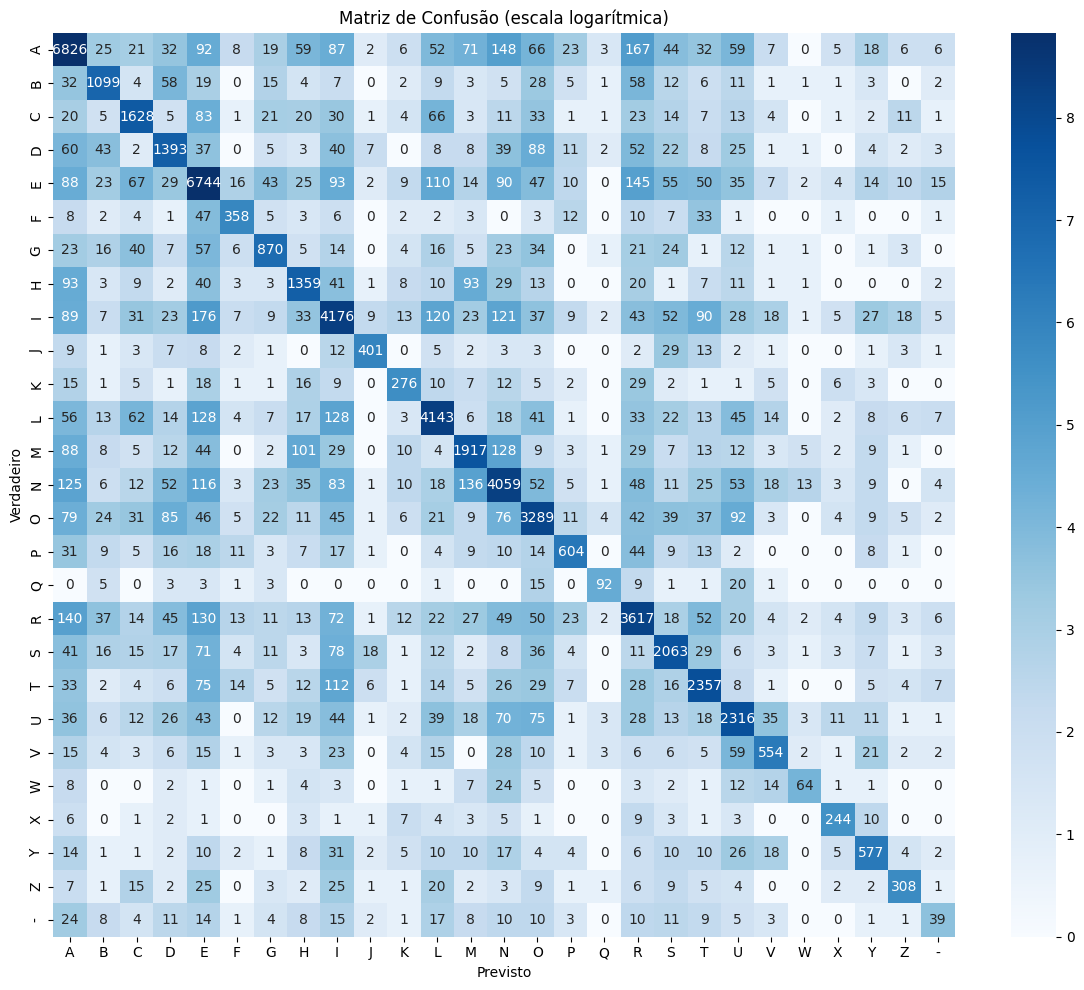


Exemplos de palavras mal classificadas:


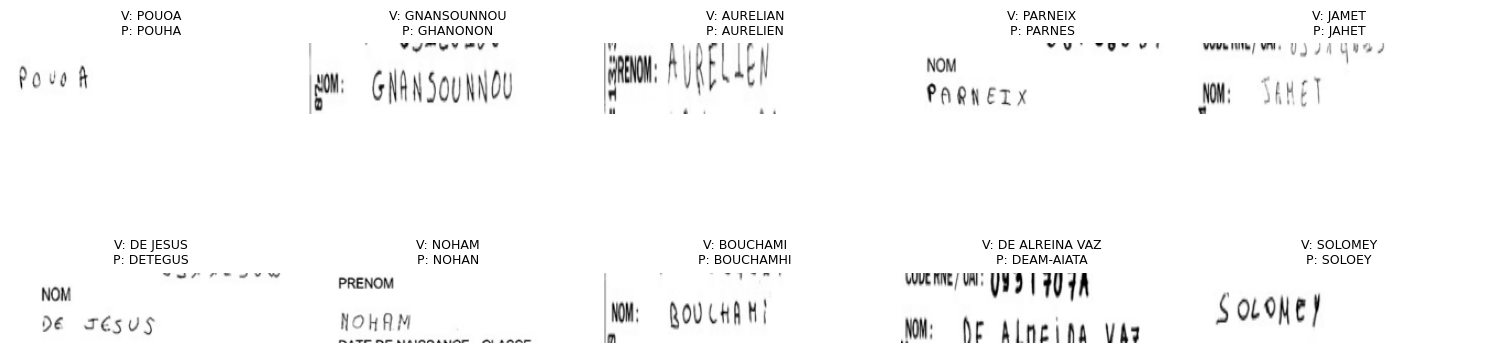

In [23]:
modelo = load_model("modelo78.pt")

avaliar_completa(modelo, 1, 1, 10)

# Conclusão

O objetivo deste projeto foi desenvolver um modelo de reconhecimento de palavras manuscritas utilizando uma rede neuronal CRNN (Convolutional Recurrent Neural Network). A base de dados utilizada foi [Kaggle Handwriting Recognition Dataset](https://www.kaggle.com/datasets/landlord/handwriting-recognition/data), que fornece imagens de palavras escritas à mão e os seus respectivos _labels_.

Após treinar o modelo com 300.000 imagens e avaliá-lo em 10.000 imagens de teste, obtivemos os seguintes resultados:
- **78,03% de acerto em letras individuais**.
- **57,51% de acerto em palavras completas**.

Embora os resultados demonstrem que o modelo é capaz de reconhecer caracteres isolados com boa precisão, a percentagem de acertos em palavras completas ainda pode ser melhorada. Observamos que o modelo enfrenta dificuldades principalmente em:

- Letras escritas de forma semalhante.
- Palavras longas ou com conexões complexas entre letras, por exemplo, confunde frequentemente o - com o E, A, I e o L.

## Possíveis melhorias
Para aprimorar o desempenho do modelo, sugerimos as seguintes abordagens:
1. **Aumento da Quantidade de Dados**: Como o modelo é complexo, um maior número de dados permitiria-lhe ter mais exemplos de cada letra, melhorando assim a sua capacidade de previsão.
2. **Aumento da Diversidade dos Dados de Treino**: Aplicar transformações como rotação, adição de ruído e distorções às imagens para simular variações reais e tornar o modelo mais robusto.
3. **Usar um Learning Rate Dinâmico**: Ajustar o learning rate para diminuir progressivamente ao longo do período de treino.
4. **Usar outras funções RNN**: Usar outra função recorrente mais complexa como LSTM.

## Reflexão
Este projeto reforçou a importância de:
- Pré-processamento adequado para uniformizar os dados.
- Uso de funções de perda especializadas, como CTCLoss, para problemas de sequência.
- Avaliação abrangente, incluindo análise de erros e matriz de confusão.

Em resumo, o modelo desenvolvido demonstrou potencial significativo para reconhecimento de texto manuscrito. Com ajustes no pipeline de dados, arquitetura e processos de treinamento, é possível alcançar resultados ainda mais robustos e aplicáveis em cenários do mundo real, como digitalização automática de documentos históricos ou formulários manuscritos.